In [1]:
import rasterio
import tqdm
import leafmap
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from mpire import WorkerPool
from skimage.restoration import denoise_tv_bregman
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.var import VAR

# Load Burst and Denoise

In [2]:
BURST_ID = 'T167-357346-IW1'

In [3]:
df_rtc = pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [4]:
df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)

In [5]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X = np.clip(X, 0, 1)
    return (X), p

def normalize_pol_ratio(img: np.ndarray, max_factor: float = 4.):
    vmax = max_factor
    vmin = 1e-7
    
    img_out = img.copy()
    img_out = np.clip(img_out, vmin, vmax)

    img_out = (img_out - vmin) / (vmax - vmin)    
    return img_out
    

def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(X_db, weight=.2, isotropic=True, eps=1e-3)
    X_dspkl = np.power(10, X_db_dspkl / 10.)
    X_dspkl[np.isnan(X)] = np.nan
    X_dspkl = np.clip(X_dspkl, 0, 1)
    return X_dspkl

In [6]:
df_rtc_ts.shape

(102, 8)

In [8]:
I = 5
K = 30

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vv_url[I:I + K]), total=K))
arrs_vv, profiles = zip(*data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.15it/s]


In [9]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vh_url[I:I + K]), total=K))
arrs_vh, _ = zip(*data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.06it/s]


In [10]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vv_d = pool.map(despeckle_one,
                         arrs_vv, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                                                         …

In [11]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vh_d = pool.map(despeckle_one, 
                         arrs_vh, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                                                         …

## Patch Read

In [12]:
df_patch_all = pd.read_json('../6_torch_dataset/dist_s1_patch_lut.json.zip')
df_patch_all.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,2960,3184,200,424,32614,T005-008688-IW2
1,2980,3204,200,424,32614,T005-008688-IW2
2,3000,3224,200,424,32614,T005-008688-IW2
3,3020,3244,200,424,32614,T005-008688-IW2
4,2860,3084,220,444,32614,T005-008688-IW2


In [13]:
df_patches = df_patch_all[df_patch_all.jpl_burst_id == BURST_ID].reset_index(drop=True)
df_patches.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,260,484,180,404,32636,T167-357346-IW1
1,280,504,180,404,32636,T167-357346-IW1
2,300,524,180,404,32636,T167-357346-IW1
3,320,544,180,404,32636,T167-357346-IW1
4,340,564,180,404,32636,T167-357346-IW1


In [14]:
C = 3
for c in range(C):
    for d in range(c, C):
        print(c, d)

0 0
0 1
0 2
1 1
1 2
2 2


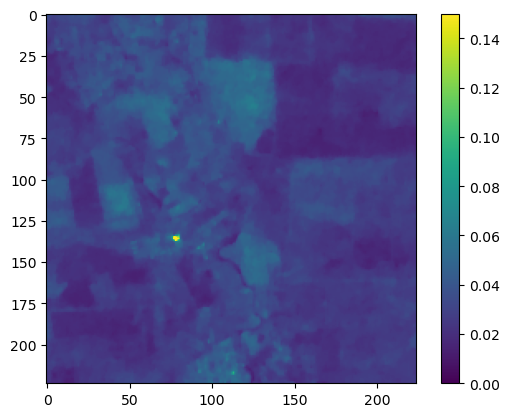

In [15]:
J = 2000
patches = df_patches.to_dict('records')
r = patches[J]

sy = np.s_[r['y_start']: r['y_stop']]
sx = np.s_[r['x_start']: r['x_stop']]

plt.imshow(arrs_vh_d[0][sy, sx], vmin=0, vmax=.15)
plt.colorbar()

# Mahalonobis 2d

Important Notes:

- As in the 1d case, we want to ensure that the distance $d$ defined as $d:= \sqrt{(x - \mu)^T \Sigma^{-1}(x - \mu)}$ does not "explode" due to "small" $\Sigma$ values. In the 1d case, we swapped out $\sigma$ with $\widehat \sigma : = \max (\sigma, .01)$. Here we have a similar approach. We perform this "clipping" operation on the eigenvalues of $\Sigma$. I use the word "clip" here because of `np.clip`, but formally this is `maximum`.
- To do this "clipping", we need to compute eigenvectors/eigenvalues for each pixel. This can be done relatively quickly (i.e. by vectorized computation) because $2 \times 2$ matrices have closed forms for such computations.
- There are probably errors and we should test each part more carefully!
- Again, all statistics are collected in a $3 \times 3$ spatial patch and through time.
- In the 1d case, we stored the pre-images as a list of images. To assist in vectorized speedup, we store the preimages as a huge array. Specifically as $T \times 2 \times H \times W$, where T is the temporal dimension, 2 is dual polarization, and the $H \times W$ are the spatial dimensions. The covariance matrix (sampled over time and the local patch) will have size $2 \times 2 \times H \times W$.

In [16]:
from astropy.convolution import convolve

def get_spatiotemporal_mu_1d(arrs: np.ndarray,
                             kernel_width=3,
                             kernel_height=3) -> np.ndarray:
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    mus_spatial = convolve(arrs, 
                           kernel, 
                           boundary="extend", 
                           nan_treatment='interpolate')
    mu_st = np.mean(mus_spatial, axis=0)
    return mu_st

def get_spatiotemporal_var_1d(arrs: np.ndarray,
                              mu_st=None,
                              kernel_width=3,
                              kernel_height=3
                              ) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    var_s = convolve((arrs - mu_st)**2, 
                     kernel, 
                     boundary="extend", 
                     nan_treatment='interpolate')
    var_st = np.mean(var_s, axis=0) 
    return var_st

def get_spatiotemporal_cor(arrs: np.ndarray,
                                mu_st=None,
                                kernel_width=3,
                                kernel_height=3
                              ) -> np.ndarray:
    _, C, _, _ = arrs.shape
    if C != 2:
        raise ValueError('input arrs must have 2 channels!')
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    CC, _, _ = mu_st.shape
    if CC != 2:
        raise ValueError('spatiotemporal mean must be 2!')
    
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)

    covar_s = convolve((arrs[:, 0, ...] - mu_st[0, ...]) * (arrs[:, 1, ...] - mu_st[1, ...]), 
                       kernel, 
                       boundary="extend", 
                       nan_treatment='interpolate')
    covar_st = np.mean(covar_s, axis=0) 
    return covar_st


def get_spatiotemporal_mu(arrs: np.ndarray,
                             kernel_width=3,
                             kernel_height=3) -> np.ndarray:
    T, C, H, W = arrs.shape
    mu_st = np.full((C, H, W), np.nan)
    for c in range(C):
        mu_st[c,...] = get_spatiotemporal_mu_1d(arrs[:, c, ...])
    
    return mu_st

def get_spatiotemporal_covar(arrs: np.ndarray,
                              mu_st=None,
                              kernel_width=3,
                              kernel_height=3
                              ) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    T, C, H, W = arrs.shape
    cov_st = np.full((C, C, H, W), np.nan)
    for c in range(C):
        cov_st[c, c,...] = get_spatiotemporal_var_1d(arrs[:, c, ...], 
                                                     mu_st=mu_st[c, ...], 
                                                     kernel_width=kernel_width, 
                                                     kernel_height=kernel_height)
    for c in range(C):
        for d in range(c, C):
            if c != d:

                covar_temp = get_spatiotemporal_cor(arrs[:, [c, d], ...], 
                                                    mu_st=mu_st[[c, d], ...], 
                                                    kernel_width=kernel_width, 
                                                    kernel_height=kernel_height)
                print(cov_st[c, d,...].shape)
                print(covar_temp.shape)
                cov_st[c, d,...] = cov_st[d, c,...] = covar_temp
    return cov_st

def invert_2d_cov(cov: np.ndarray) -> np.ndarray:
    det = cov[0, 0, ...] * cov[1, 1, ...] - 2 * cov[0, 1, ...]
    covar_inv = np.full(cov.shape, np.nan)
    covar_inv[0, 0, ...] = 1 / det * cov[1, 1, ...]
    covar_inv[1, 1, ...] = 1 / det * cov[0, 0, ...]
    t = - 1 / det * cov[0, 1, ...]
    covar_inv[0, 1, ...] = t
    covar_inv[1, 0, ...] = t
    return covar_inv

def get_eigh_2by2(cov_mat: np.ndarray) -> np.ndarray:
    """
    References:
    https://math.stackexchange.com/questions/395698/fast-way-to-calculate-eigen-of-2x2-matrix-using-a-formula
    https://people.math.harvard.edu/~knill/teaching/math21b2004/exhibits/2dmatrices/index.html
    """
    eigval = np.diagonal(cov_mat, axis1=0, axis2=1).transpose([2, 0, 1]) # so it's 2 x H X W
    eigvec = np.zeros(cov_mat.shape)

    case_1 = (cov_mat[0, 1, ...] != 0)
    case_2 = ~case_1

    case_1_cov = cov_mat[..., case_1]
    case_1_eigval = eigval[..., case_1]
    
    case_2_cov = cov_mat[..., ~case_1]
    case_2_eigval = eigval[..., ~case_1]
    
    eigvec[0, 0, case_1] = case_1_eigval[0, ...] - case_1_cov[1, 1, ...]
    eigvec[1, 0, case_1] = case_1_cov[0, 1, ...]
    
    # Make sure the eigenvector is normalized so that the matrix of eigenvectors has an inverse that is its transpose
    n = np.sqrt(eigvec[1, 0, case_1] ** 2 + eigvec[0, 0, case_1]**2)
    eigvec[0, 0, case_1] /= n
    eigvec[1, 0, case_1] /= n

    eigvec[0, 1, case_1] = case_1_eigval[1, ...] - case_1_cov[1, 1, ...]
    eigvec[1, 1, case_1] = case_1_cov[1, 0, ...]

    # Make sure the eigenvector is normalized so that the matrix of eigenvectors has an inverse that is its transpose
    n = np.sqrt(eigvec[0, 1, case_1] ** 2 + eigvec[1, 1, case_1]**2)
    eigvec[0, 1, case_1] /= n
    eigvec[1, 1, case_1] /= n

    eigvec[0, 0, case_2] = 1
    eigvec[1, 1, case_2] = 1
    
    return eigval, eigvec


def get_mahalanobis_dist(pre_arrs: np.ndarray,
                         post_arr: np.ndarray,
                         min_sigma: float = .01,
                         kernel_width=3,
                         kernel_height=3) -> tuple[np.ndarray]:
                
    mu_st = get_spatiotemporal_mu(pre_arrs, 
                                  kernel_width=kernel_width, 
                                  kernel_height=kernel_height)
    covar_st = get_spatiotemporal_covar(pre_arrs, 
                                        mu_st=mu_st, 
                                        kernel_width=kernel_width, 
                                        kernel_height=kernel_height)
    # covar_st_floor = np.sign(covar_st) * np.maximum(np.abs(covar_st), min_sigma)
    # covar_st_inv = invert_2d_cov(covar_st)

    eigval, eigvec = get_eigh_2by2(covar_st)
    # This is the floor we discused earlier
    eigval_inv_floor = (np.maximum(eigval, .01)) ** -1

    # Diag matrix is the diagonal matrix of eigenvalues
    diag_matrix = np.zeros(eigvec.shape, dtype=np.float32)
    diag_matrix[0, 0, ...] = eigval_inv_floor[0, ...] 
    diag_matrix[1, 1, ...] = eigval_inv_floor[1, ...]

    # Matrix multiplication to reconstruct the Sigma^-1  = V^T D V where V is the 
    # matrix whose colums are eignevectors and D is the diagonal matrix of eigenvalues
    covar_st_inv_floor_t = np.einsum('ijmn,jkmn->ikmn', diag_matrix, eigvec)
    covar_st_inv_floor = np.einsum('ijmn,jkmn->ikmn', eigvec.transpose([1, 0, 2, 3]), covar_st_inv_floor_t)
    
    # Finally compute the Mahalanobis distance!
    vec = post_arr - mu_st
    dist_0 = np.einsum('ijkl,jkl->ikl', covar_st_inv_floor, vec)
    dist_1 = np.einsum('ijk,ijk->jk', vec, dist_0)
    dist = np.sqrt(dist_1)
    return mu_st, covar_st, dist, dist_0, dist_1, vec, covar_st_inv_floor, covar_st_inv_floor_t, eigval_inv_floor, eigval, diag_matrix

https://math.stackexchange.com/questions/395698/fast-way-to-calculate-eigen-of-2x2-matrix-using-a-formula

In [17]:
dual_pol = [np.stack([vv, vh], axis=0) for (vv, vh) in zip(arrs_vv_d, arrs_vh_d)]
ts = np.stack(dual_pol, axis=0)
ts.shape

(30, 2, 1477, 3305)

In [39]:
P = 15
pre = ts[:P, ...]
post = ts[P, ...]
post.shape

(2, 1477, 3305)

In [40]:
m, c, d, d0, d1, vec, cinv, cinv0, vals_inv, vals, diag = get_mahalanobis_dist(pre, post)

(1477, 3305)
(1477, 3305)


https://math.stackexchange.com/questions/395698/fast-way-to-calculate-eigen-of-2x2-matrix-using-a-formula
https://people.math.harvard.edu/~knill/teaching/math21b2004/exhibits/2dmatrices/index.html

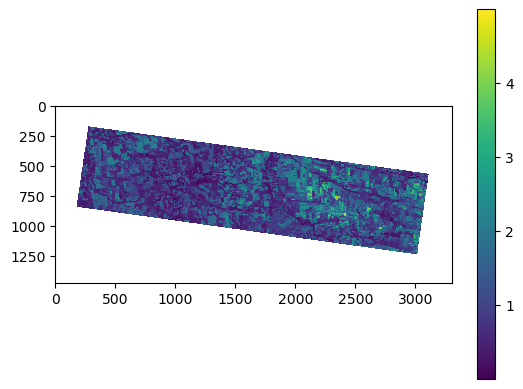

In [41]:
plt.imshow(d, interpolation='none')
plt.colorbar()

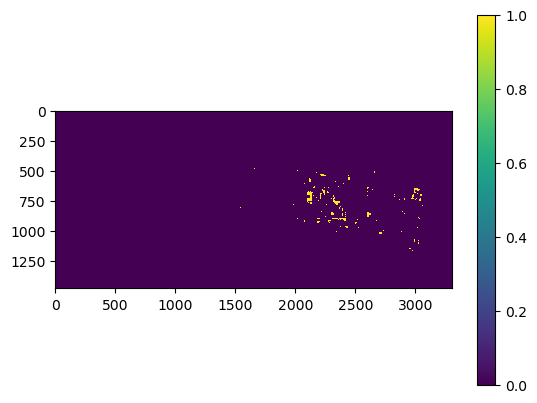

In [42]:
plt.imshow(d > 3, interpolation='none', vmin=0, vmax=1)
plt.colorbar()